In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import pmdarima as pm
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import timedelta
from math import sqrt
from sklearn.metrics import mean_squared_error

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
panel = pd.read_csv('Panel_Data.csv')

In [4]:
global_df = pd.read_csv('GlobalTemperatures.csv')

In [5]:
global_df['Year'] = pd.to_datetime(global_df['dt']).dt.year

In [6]:
# dataframe for yearly average temperature and uncertainty
group_global = global_df.groupby(['Year']).agg({ 
    'LandAverageTemperature': 'mean',
    'LandAverageTemperatureUncertainty': 'mean'
}).reset_index()

In [7]:
group_global.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 3 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Year                               266 non-null    int64  
 1   LandAverageTemperature             266 non-null    float64
 2   LandAverageTemperatureUncertainty  266 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 6.4 KB


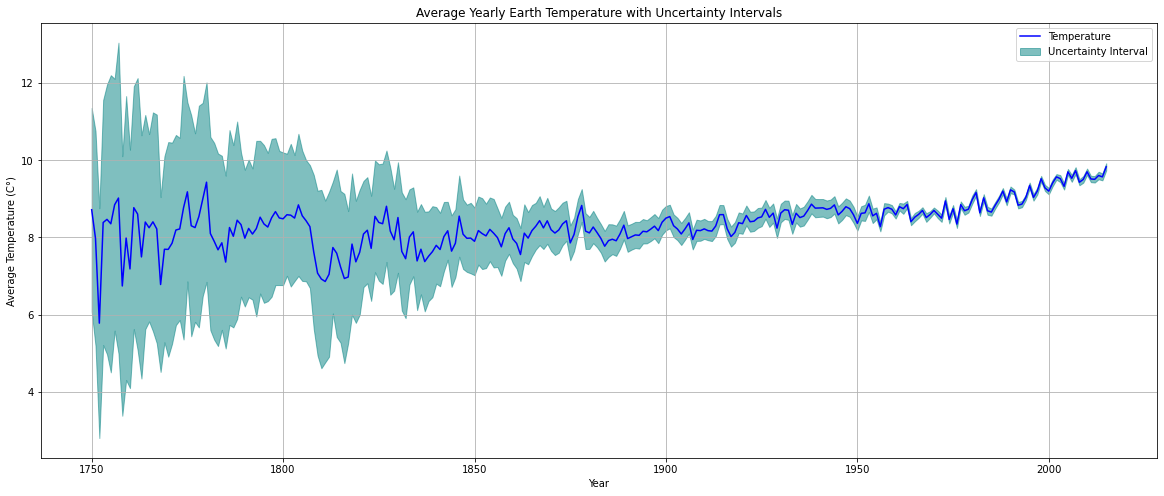

In [8]:
# plot global temperature over time with uncertainty range
plt.figure(figsize=(20, 8))

plt.plot(group_global['Year'], group_global['LandAverageTemperature'], label='Temperature', color='blue')

plt.fill_between(group_global['Year'], group_global['LandAverageTemperature'] - group_global['LandAverageTemperatureUncertainty'],
                 group_global['LandAverageTemperature'] + group_global['LandAverageTemperatureUncertainty'],
                 color='teal', alpha=0.5, label='Uncertainty Interval')

plt.title('Average Yearly Earth Temperature with Uncertainty Intervals')
plt.xlabel('Year')
plt.ylabel('Average Temperature (C°)')
plt.legend()
plt.grid(True)

plt.show()

In [9]:
group_global['date'] = pd.to_datetime(group_global['Year'].astype(str) + '-01-01')

# Drop the original 'year' column if needed
group_global.drop('Year', axis=1, inplace=True)

In [10]:
group_global.head()

,LandAverageTemperature,LandAverageTemperatureUncertainty,date
0,8.719364,2.637818,1750-01-01
1,7.976143,2.781143,1751-01-01
2,5.779833,2.977000,1752-01-01
3,8.388083,3.176000,1753-01-01
4,8.469333,3.494250,1754-01-01


In [11]:
global_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3180 entries, 0 to 3179
Data columns (total 10 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   dt                                         3180 non-null   object 
 1   LandAverageTemperature                     3180 non-null   float64
 2   LandAverageTemperatureUncertainty          3180 non-null   float64
 3   LandMaxTemperature                         1992 non-null   float64
 4   LandMaxTemperatureUncertainty              1992 non-null   float64
 5   LandMinTemperature                         1992 non-null   float64
 6   LandMinTemperatureUncertainty              1992 non-null   float64
 7   LandAndOceanAverageTemperature             1992 non-null   float64
 8   LandAndOceanAverageTemperatureUncertainty  1992 non-null   float64
 9   Year                                       3180 non-null   int64  
dtypes: float64(8), int64(1),

In [12]:
gdf2 = global_df[['dt', 'LandAverageTemperature', 'LandAverageTemperatureUncertainty', 'Year']]
gdf2.head()

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,Year
0,1750-01-01,3.034,3.574,1750
1,1750-02-01,3.083,3.702,1750
2,1750-03-01,5.626,3.076,1750
3,1750-04-01,8.490,2.451,1750
4,1750-05-01,11.573,2.072,1750


In [13]:
# convert dt to datetime object
gdf2['dt'] = pd.to_datetime(gdf2['dt'], format='%Y-%m')

In [14]:
# make date the index of the dataframe
gdf2.index = gdf2['dt']
del gdf2['dt']

In [15]:
print(gdf2.head())

            LandAverageTemperature  LandAverageTemperatureUncertainty  Year
dt                                                                         
1750-01-01                   3.034                              3.574  1750
1750-02-01                   3.083                              3.702  1750
1750-03-01                   5.626                              3.076  1750
1750-04-01                   8.490                              2.451  1750
1750-05-01                  11.573                              2.072  1750


In [16]:
# grouped global data frame
ggdf = group_global

In [17]:
# make index of ggdf date
ggdf.index = ggdf['date']
del ggdf['date']
print(ggdf.head())

            LandAverageTemperature  LandAverageTemperatureUncertainty
date                                                                 
1750-01-01                8.719364                           2.637818
1751-01-01                7.976143                           2.781143
1752-01-01                5.779833                           2.977000
1753-01-01                8.388083                           3.176000
1754-01-01                8.469333                           3.494250


In [18]:
del ggdf['LandAverageTemperatureUncertainty']

### Time Series Statistics / Plots

In [19]:
rolling_mean = ggdf.rolling(10).mean()
rolling_std = ggdf.rolling(10).std()

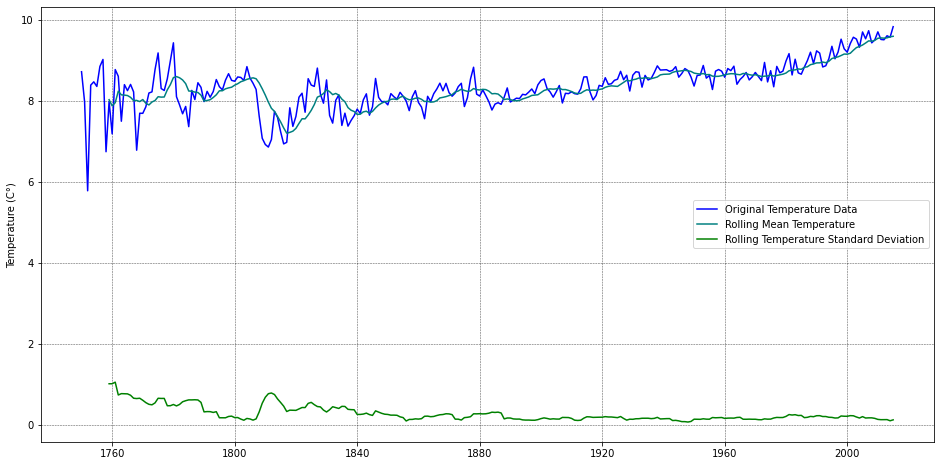

In [20]:
# plot rolling mean and std with temperature data
plt.figure(figsize=(16, 8))
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='black')
plt.plot(ggdf, color='blue', label = 'Original Temperature Data')
plt.plot(rolling_mean, color='teal', label = 'Rolling Mean Temperature')
plt.plot(rolling_std, color='green', label = 'Rolling Temperature Standard Deviation')
plt.ylabel('Temperature (C°)')
plt.legend(loc=7)
plt.show()

In [21]:
# Dickey Fuller Stationarity Test
adft = adfuller(ggdf, autolag='AIC')

In [22]:
# Format Dickey Fuller Output
output_df = pd.DataFrame({"Metric":["Test Statistics","*p-value","No. of lags used","Number of observations used", "critical value (1%)", "critical value (5%)", "critical value (10%)"]  , 
"Value": [adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]})
print(output_df)
print('*Not Stationary!')

                        Metric       Value
0              Test Statistics   -0.191872
1                     *p-value    0.939484
2             No. of lags used   15.000000
3  Number of observations used  250.000000
4          critical value (1%)   -3.456781
5          critical value (5%)   -2.873172
6         critical value (10%)   -2.572969
*Not Stationary!


In [23]:
# 1 year lag autocorrelation
autocorr1 = ggdf['LandAverageTemperature'].autocorr(lag=1)
autocorr1

0.72507486219107

In [24]:
# 3 year lag autocorelation
autocorr3 = ggdf['LandAverageTemperature'].autocorr(lag=3)
autocorr3

0.6414517893885482

In [25]:
# 5 year lag autocorrelation
autocorr5 = ggdf['LandAverageTemperature'].autocorr(lag=5)
autocorr5

0.587007064162747

In [26]:
# create 13 year subset of monthly data
gdf13 = gdf2.tail(156)

In [27]:
gdf13

,LandAverageTemperature,LandAverageTemperatureUncertainty,Year
dt,,,
2003-01-01,3.981,0.070,2003
2003-02-01,4.085,0.097,2003
2003-03-01,6.048,0.055,2003
2003-04-01,9.154,0.074,2003
2003-05-01,12.153,0.095,2003
...,...,...,...
2015-08-01,14.755,0.072,2015
2015-09-01,12.999,0.079,2015
2015-10-01,10.801,0.102,2015


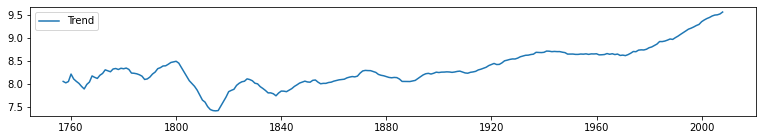

In [28]:
# use seasonal decomposition on entire dataset to further visualize trend 
result = seasonal_decompose(ggdf['LandAverageTemperature'], model='additive', period=15)
trend = result.trend
plt.figure(figsize=(13, 2))
plt.plot(trend, label='Trend')
plt.legend()
plt.show()

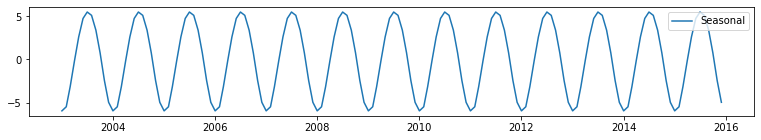

In [29]:
# use seasonal decompostion on 13 year subset of monthly data to visualize seasonal pattern
result = seasonal_decompose(gdf13['LandAverageTemperature'], model='additive', period=12)
seasonal = result.seasonal
plt.figure(figsize=(13, 2))
plt.plot(seasonal, label='Seasonal')
plt.legend()
plt.show()

### Forecasting

In [30]:
df = ggdf.copy()

In [31]:
# trim data to since 1916 (100 years)
df['Date'] = df.index
df = df[df['Date'].dt.year > 1915]

In [32]:
df.head()

,LandAverageTemperature,Date
date,,
1916-01-01,8.225250,1916-01-01
1917-01-01,8.023333,1917-01-01
1918-01-01,8.130833,1918-01-01
1919-01-01,8.382250,1919-01-01
1920-01-01,8.358750,1920-01-01


In [33]:
# train = 1916 - 1995
train = df[df['Date'].dt.year <= 1995]
train['train'] = train['LandAverageTemperature']
del train['Date']
del train['LandAverageTemperature']

In [34]:
# test = 1995 - 2015
test = df[df['Date'].dt.year > 1995]
del test['Date']
test['test'] = test['LandAverageTemperature']
del test['LandAverageTemperature']

In [35]:
train

,train
date,
1916-01-01,8.225250
1917-01-01,8.023333
1918-01-01,8.130833
1919-01-01,8.382250
1920-01-01,8.358750
...,...
1991-01-01,9.179417
1992-01-01,8.836583
1993-01-01,8.866583


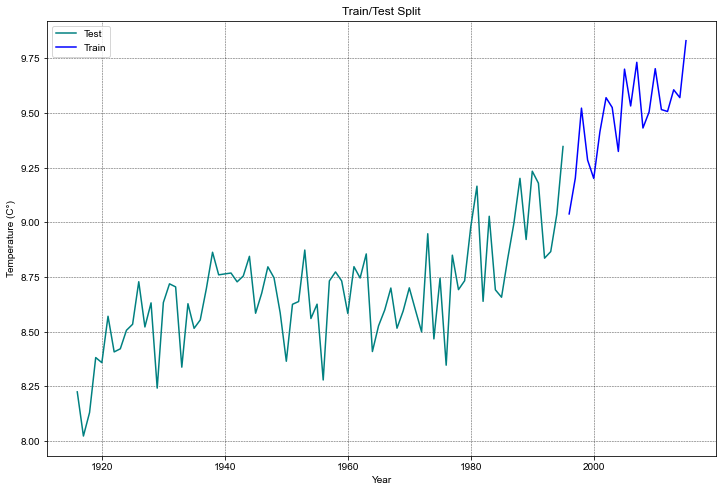

In [36]:
plt.figure(figsize=(12,8))
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='black')
plt.plot(train, color = 'teal', label='Test')
plt.plot(test, color = 'blue', label='Train')
plt.title('Train/Test Split')
plt.ylabel('Temperature (C°)')
plt.xlabel('Year')
plt.legend()
sns.set()
plt.show()

In [37]:
model = auto_arima(train, trace=True, error_action='ignore', supress_warnings=True)
model.fit(train)
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast, index=test.index, columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-37.862, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5.551, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-27.045, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-39.723, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7.244, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-37.724, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-37.724, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-38.840, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-37.611, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.525 seconds


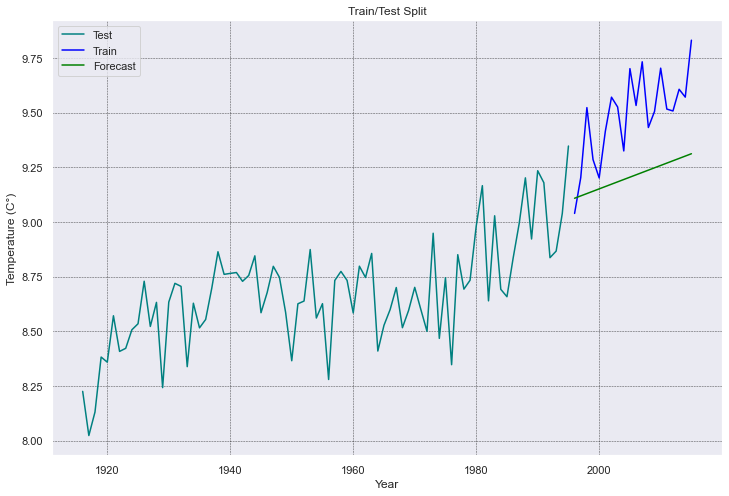

In [38]:
plt.figure(figsize=(12,8))
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='black')
plt.plot(train, color = 'teal', label='Test')
plt.plot(test, color = 'blue', label='Train')
plt.plot(forecast, color = 'green', label='Forecast')
plt.title('Train/Test Split')
plt.ylabel('Temperature (C°)')
plt.xlabel('Year')
plt.legend()
sns.set()
plt.show()

In [39]:
first_forecast = forecast.copy()

In [40]:
rms = sqrt(mean_squared_error(test,forecast))
print("RMSE: ", rms)

RMSE:  0.31671538349088046


#### Model Seems to be predicting low because its training data is prior to increased global warming... Going to try shifting the data to past ~ 45 years

In [41]:
# train = 1916 - 1995
train = df[(df['Date'].dt.year >= 1970) & (df['Date'].dt.year < 2005)]
train['train'] = train['LandAverageTemperature']
del train['Date']
del train['LandAverageTemperature']
train

,train
date,
1970-01-01,8.700917
1971-01-01,8.599250
1972-01-01,8.499583
1973-01-01,8.948250
1974-01-01,8.467500
1975-01-01,8.744833
1976-01-01,8.347250
1977-01-01,8.850250
1978-01-01,8.692750


In [42]:
# test = 2007 - 2015
test = df[df['Date'].dt.year >= 2005]
del test['Date']
test['test'] = test['LandAverageTemperature']
del test['LandAverageTemperature']

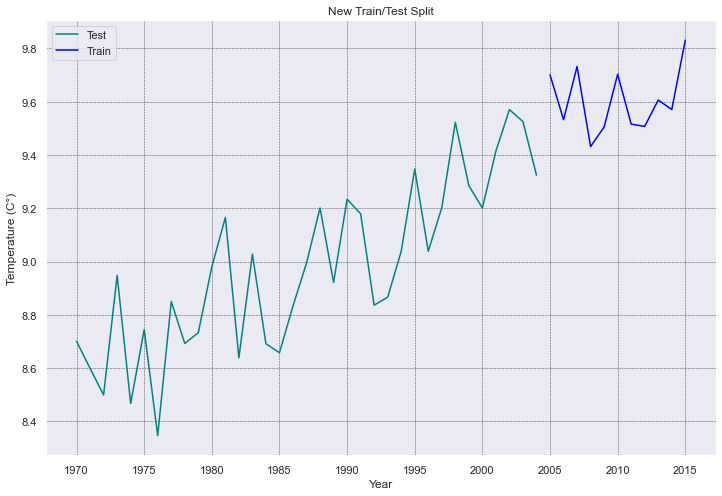

In [43]:
# new train test split
plt.figure(figsize=(12,8))
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='black')
plt.plot(train, color = 'teal', label='Test')
plt.plot(test, color = 'blue', label='Train')
plt.title('New Train/Test Split')
plt.ylabel('Temperature (C°)')
plt.xlabel('Year')
plt.legend()
sns.set()
plt.show()

In [44]:
model = pm.auto_arima(train, trace=True, error_action='ignore', supress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11.954, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.690, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10.108, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=0.945, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-0.023, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1.951, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=0.729, Time=0.02 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0] intercept
Total fit time: 1.017 seconds


In [45]:
arima_model = pm.ARIMA(order = model.order, seasonal_order=model.seasonal_order)
fitted_model = arima_model.fit(train)

In [46]:
print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   35
Model:               SARIMAX(3, 1, 0)   Log Likelihood                   5.011
Date:                Tue, 05 Dec 2023   AIC                             -0.023
Time:                        21:36:01   BIC                              7.609
Sample:                    01-01-1970   HQIC                             2.580
                         - 01-01-2004                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0652      0.041      1.604      0.109      -0.014       0.145
ar.L1         -0.8058      0.201     -4.001      0.000      -1.200      -0.411
ar.L2         -0.5363      0.227     -2.359      0.0

In [47]:
#model.fit(train)

In [48]:
forecast = fitted_model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast, index=test.index, columns=['Prediction'])

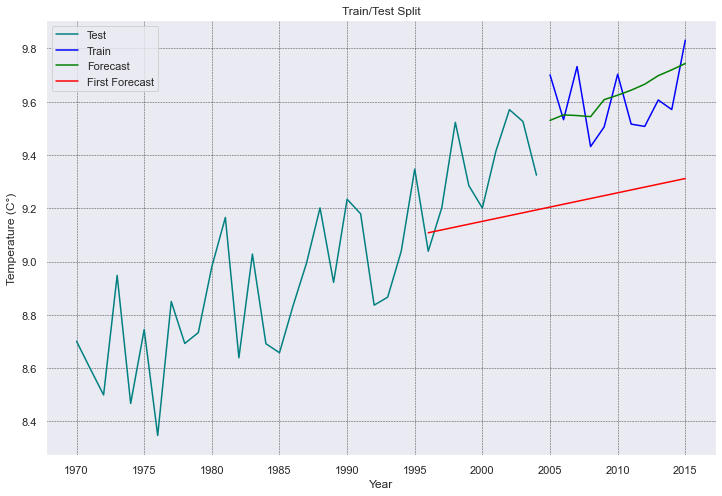

In [49]:
plt.figure(figsize=(12,8))
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='black')
plt.plot(train, color = 'teal', label='Test')
plt.plot(test, color = 'blue', label='Train')
plt.plot(forecast, color = 'green', label='Forecast')
plt.plot(first_forecast, color = 'red', label='First Forecast')
plt.title('Train/Test Split')
plt.ylabel('Temperature (C°)')
plt.xlabel('Year')
plt.legend()
sns.set()
plt.show()

In [50]:
rms = sqrt(mean_squared_error(test,forecast))
print("RMSE: ", rms)

RMSE:  0.12511373735732215
